# Enhanced Traveling Wave PINN with Fourier Features & Causal Training

このノートブックは、Fourier FeaturesとCausal Trainingを統合した進行波PINNの実装です。

## 改善点

1. **Fourier Features**: 高周波成分の学習を改善
2. **Causal Training**: 時間的因果律を強制し、物理的に妥当な解を学習

## 問題設定

**波動方程式**: $\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$

**境界条件**: Neumann BC（自由端） - $\frac{\partial u}{\partial x} = 0$ at boundaries

**初期条件**: Gaussian pulse $u(x,0) = A \exp\left(-\frac{(x-x_0)^2}{2\sigma^2}\right)$

## Setup

In [22]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from pinn.models.pinn_model_builder import PINNModelBuilderService
from pinn.training.training_pipeline import TrainingPipelineService
from pinn.training.callbacks import LossLoggingCallback, ValidationCallback
from pinn.validation.analytical_solutions import AnalyticalSolutionGeneratorService
from pinn.validation.error_metrics import ErrorMetricsService
from pinn.validation.plot_generator import PlotGeneratorService
from pinn.utils.config_loader import ConfigLoaderService
from pinn.utils.seed_manager import SeedManager
from pinn.utils.experiment_manager import ExperimentManager

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 10)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.4.0+cu124
CUDA available: True


## Configuration

### 重要: Fourier Features & Causal Training を有効化

In [23]:
config_path = project_root / "configs" / "traveling_wave_improved.yaml"
config_loader = ConfigLoaderService()
config = config_loader.load_config(config_path)

# ===== Enhanced Features を有効化 =====
config.network.use_fourier_features = True
config.training.use_causal_training = True
# ======================================

# Set seed for reproducibility
SeedManager.set_seed(config.seed)

print("=" * 80)
print("ENHANCED PINN CONFIGURATION")
print("=" * 80)
print(f"Experiment: {config.experiment_name}")
print(f"\nDomain:")
print(f"  x ∈ [{config.domain.x_min}, {config.domain.x_max}]")
print(f"  t ∈ [{config.domain.t_min}, {config.domain.t_max}]")
print(f"  Wave speed: c = {config.domain.wave_speed}")
print(f"\nBoundary condition: {config.boundary_conditions.type}")
print(f"\nNetwork:")
print(f"  Architecture: {config.network.layer_sizes}")
print(f"  Fourier Features: {config.network.use_fourier_features}")
print(f"\nTraining:")
print(f"  Epochs: {config.training.epochs}")
print(f"  Causal Training: {config.training.use_causal_training}")
print("=" * 80)

ENHANCED PINN CONFIGURATION
Experiment: traveling_wave_improved

Domain:
  x ∈ [0.0, 2.0]
  t ∈ [0.0, 2.0]
  Wave speed: c = 1.5

Boundary condition: neumann

Network:
  Architecture: [2, 128, 128, 128, 128, 1]
  Fourier Features: True

Training:
  Epochs: 10000
  Causal Training: True


## Define Initial Condition

Initial condition: Gaussian pulse
  Center: x0 = 1.0
  Width: σ = 0.2
  Amplitude: A = 1.0


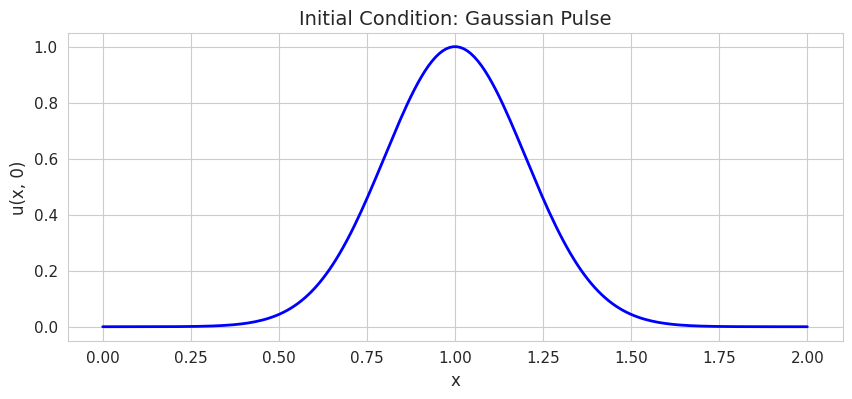

In [24]:
# Gaussian pulse parameters
L = config.domain.x_max - config.domain.x_min
x0 = L / 2  # Center of domain
sigma = L / 10  # Width of pulse
amplitude = config.analytical_solution.initial_amplitude


def initial_condition(x):
    """Gaussian pulse initial condition."""
    if x.ndim == 1:
        x_reshaped = x.reshape(-1, 1)
    else:
        x_reshaped = x if x.shape[1] >= 1 else x.reshape(-1, 1)
    return amplitude * np.exp(-((x_reshaped[:, 0:1] - x0) ** 2) / (2 * sigma**2))


print(f"Initial condition: Gaussian pulse")
print(f"  Center: x0 = {x0}")
print(f"  Width: σ = {sigma}")
print(f"  Amplitude: A = {amplitude}")

# Visualize
x_plot = np.linspace(config.domain.x_min, config.domain.x_max, 200)[:, None]
u_initial = initial_condition(x_plot)

plt.figure(figsize=(10, 4))
plt.plot(x_plot, u_initial, "b-", linewidth=2)
plt.xlabel("x", fontsize=12)
plt.ylabel("u(x, 0)", fontsize=12)
plt.title("Initial Condition: Gaussian Pulse", fontsize=14)
plt.grid(True)
plt.show()

## Calculate Wave Reflection Time

In [25]:
# Calculate time for wave to reach boundaries
c = config.domain.wave_speed
distance_to_boundary = min(x0 - config.domain.x_min, config.domain.x_max - x0)
t_reflection = distance_to_boundary / c

print(f"Wave propagation analysis:")
print(f"  Wave speed: c = {c}")
print(f"  Distance to nearest boundary: {distance_to_boundary}")
print(f"  Time to reach boundary: t_reflection ≈ {t_reflection:.3f}")
print(f"\n✓ 解析解も反射を考慮するため、全時間範囲で比較可能")

Wave propagation analysis:
  Wave speed: c = 1.5
  Distance to nearest boundary: 1.0
  Time to reach boundary: t_reflection ≈ 0.667

✓ 解析解も反射を考慮するため、全時間範囲で比較可能


## Build Enhanced PINN Model

### Fourier Features + Causal Training

In [26]:
model_builder = PINNModelBuilderService()
model = model_builder.build_model(config=config, initial_condition_func=initial_condition, compile_model=True)

print("Enhanced PINN model built successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.net.parameters() if p.requires_grad):,}")

# Check features
if config.network.use_fourier_features:
    print("\n✓ Fourier Features ENABLED")
else:
    print("\n✗ Fourier Features disabled")

if config.training.use_causal_training:
    print("✓ Causal Training ENABLED")
else:
    print("✗ Causal Training disabled")

Using Causal PDE with β=0.5
Compiling model...
'compile' took 0.000432 s

Enhanced PINN model built successfully!
Total parameters: 82,561

✓ Fourier Features ENABLED
✓ Causal Training ENABLED


## Setup Callbacks

In [27]:
# Create experiment directory
exp_manager = ExperimentManager(base_dir=project_root / "experiments")
exp_dir = exp_manager.create_experiment_directory("traveling_wave_enhanced")

# Services
analytical_solver = AnalyticalSolutionGeneratorService()
error_metrics = ErrorMetricsService()

# Loss logging
loss_callback = LossLoggingCallback(log_interval=100)

# Validation
validation_callback = ValidationCallback(
    analytical_solver=analytical_solver,
    error_metrics=error_metrics,
    validation_interval=500,
    domain_config=config.domain,
    wave_speed=config.domain.wave_speed,
    n_mode=1,
    bc_type="traveling_wave",
    initial_condition_func=initial_condition,
    enable_validation=True,
)

callbacks = [loss_callback, validation_callback]

print(f"Callbacks created: {len(callbacks)}")
print(f"Experiment directory: {exp_dir}")

Callbacks created: 2
Experiment directory: /home/manat/project3/experiments/traveling_wave_enhanced_2026-01-08_09-44-32


## Train Model

### Fourier Features と Causal Training で学習

In [28]:
print("=" * 80)
print("Training Enhanced Traveling Wave PINN")
print("  ✓ Fourier Features: ENABLED")
print("  ✓ Causal Training: ENABLED")
print("=" * 80)

training_pipeline = TrainingPipelineService()

trained_model, training_history = training_pipeline.train(
    model=model, config=config.training, output_dir=exp_dir, callbacks=callbacks
)

print("\nTraining completed!")

Training Enhanced Traveling Wave PINN
  ✓ Fourier Features: ENABLED
  ✓ Causal Training: ENABLED
Training model...

0         [1.08e+05, 1.12e+03, 1.72e+02, 7.56e+01]    [1.08e+05, 1.12e+03, 1.72e+02, 7.56e+01]    []  
1000      [3.68e+00, 2.45e+00, 5.33e+00, 3.62e+00]    [3.68e+00, 2.45e+00, 5.33e+00, 3.62e+00]    []  
2000      [2.20e+00, 2.14e+00, 4.05e+00, 4.22e+00]    [2.20e+00, 2.14e+00, 4.05e+00, 4.22e+00]    []  
3000      [1.83e+00, 2.06e+00, 3.70e+00, 4.07e+00]    [1.83e+00, 2.06e+00, 3.70e+00, 4.07e+00]    []  
4000      [1.63e+00, 1.84e+00, 3.41e+00, 3.73e+00]    [1.63e+00, 1.84e+00, 3.41e+00, 3.73e+00]    []  
5000      [1.48e+00, 1.53e+00, 3.23e+00, 3.32e+00]    [1.48e+00, 1.53e+00, 3.23e+00, 3.32e+00]    []  
6000      [1.37e+00, 1.32e+00, 3.17e+00, 3.06e+00]    [1.37e+00, 1.32e+00, 3.17e+00, 3.06e+00]    []  
7000      [3.14e+00, 1.29e+00, 3.30e+00, 2.83e+00]    [3.14e+00, 1.29e+00, 3.30e+00, 2.83e+00]    []  
8000      [3.61e+00, 1.13e+00, 3.11e+00, 2.68e+00]    [3.61e

## Loss Components Evolution

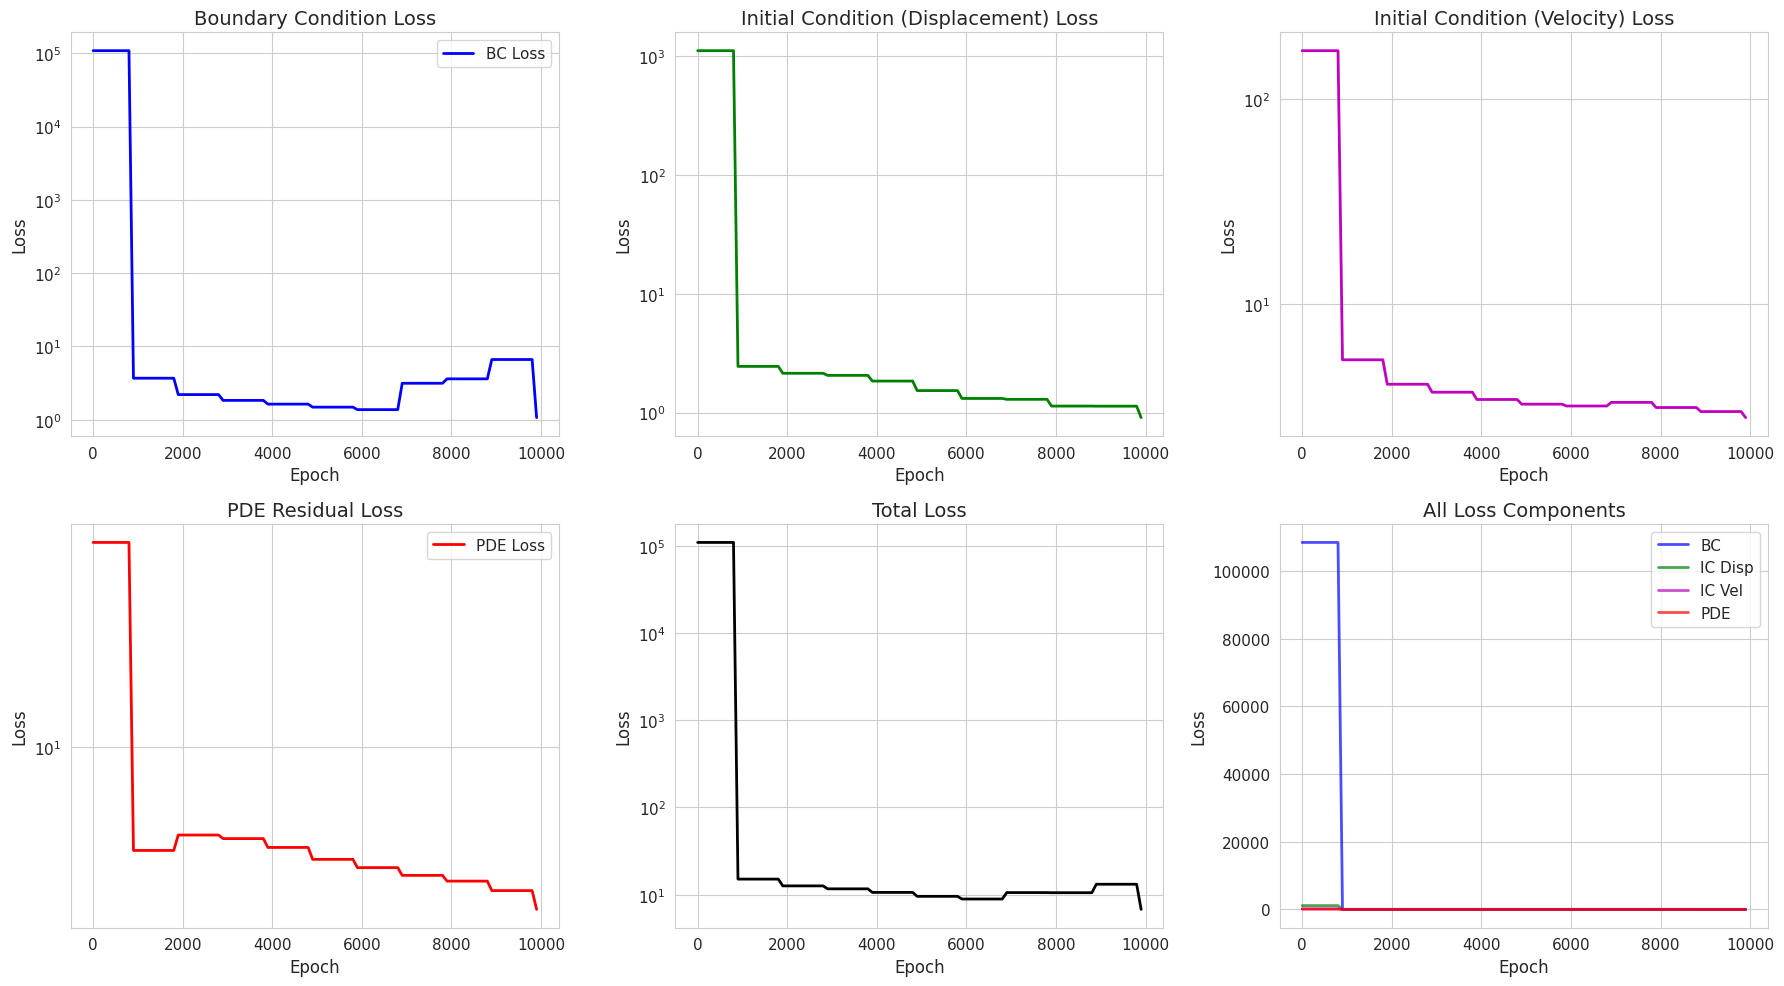


FINAL LOSS COMPONENTS
L_bc:               1.066674e+00
L_ic_displacement:  9.068689e-01
L_ic_velocity:      2.779598e+00
L_pde:              2.024626e+00
Total Loss:         6.777766e+00


In [29]:
# Plot individual loss components
if loss_callback.history["L_bc"]:
    epochs = np.arange(0, len(loss_callback.history["L_bc"])) * loss_callback.log_interval

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # BC Loss
    axes[0, 0].plot(epochs, loss_callback.history["L_bc"], "b-", linewidth=2, label="BC Loss")
    axes[0, 0].set_xlabel("Epoch", fontsize=12)
    axes[0, 0].set_ylabel("Loss", fontsize=12)
    axes[0, 0].set_title("Boundary Condition Loss", fontsize=14)
    axes[0, 0].set_yscale("log")
    axes[0, 0].grid(True)
    axes[0, 0].legend()

    # IC Displacement Loss
    axes[0, 1].plot(epochs, loss_callback.history["L_ic_displacement"], "g-", linewidth=2)
    axes[0, 1].set_xlabel("Epoch", fontsize=12)
    axes[0, 1].set_ylabel("Loss", fontsize=12)
    axes[0, 1].set_title("Initial Condition (Displacement) Loss", fontsize=14)
    axes[0, 1].set_yscale("log")
    axes[0, 1].grid(True)

    # IC Velocity Loss
    axes[0, 2].plot(epochs, loss_callback.history["L_ic_velocity"], "m-", linewidth=2)
    axes[0, 2].set_xlabel("Epoch", fontsize=12)
    axes[0, 2].set_ylabel("Loss", fontsize=12)
    axes[0, 2].set_title("Initial Condition (Velocity) Loss", fontsize=14)
    axes[0, 2].set_yscale("log")
    axes[0, 2].grid(True)

    # PDE Loss
    axes[1, 0].plot(epochs, loss_callback.history["L_pde"], "r-", linewidth=2, label="PDE Loss")
    axes[1, 0].set_xlabel("Epoch", fontsize=12)
    axes[1, 0].set_ylabel("Loss", fontsize=12)
    axes[1, 0].set_title("PDE Residual Loss", fontsize=14)
    axes[1, 0].set_yscale("log")
    axes[1, 0].grid(True)
    axes[1, 0].legend()

    # Total Loss
    axes[1, 1].plot(epochs, loss_callback.history["total_loss"], "k-", linewidth=2)
    axes[1, 1].set_xlabel("Epoch", fontsize=12)
    axes[1, 1].set_ylabel("Loss", fontsize=12)
    axes[1, 1].set_title("Total Loss", fontsize=14)
    axes[1, 1].set_yscale("log")
    axes[1, 1].grid(True)

    # All losses together
    axes[1, 2].plot(epochs, loss_callback.history["L_bc"], "b-", linewidth=2, label="BC", alpha=0.7)
    axes[1, 2].plot(epochs, loss_callback.history["L_ic_displacement"], "g-", linewidth=2, label="IC Disp", alpha=0.7)
    axes[1, 2].plot(epochs, loss_callback.history["L_ic_velocity"], "m-", linewidth=2, label="IC Vel", alpha=0.7)
    axes[1, 2].plot(epochs, loss_callback.history["L_pde"], "r-", linewidth=2, label="PDE", alpha=0.7)
    axes[1, 2].set_xlabel("Epoch", fontsize=12)
    axes[1, 2].set_ylabel("Loss", fontsize=12)
    axes[1, 2].set_title("All Loss Components", fontsize=14)
    axes[1, 2].grid(True)
    axes[1, 2].legend()

    plt.tight_layout()
    plt.savefig(exp_dir / "loss_evolution.png", dpi=150)
    plt.show()

    # Print final loss values
    print("\n" + "=" * 80)
    print("FINAL LOSS COMPONENTS")
    print("=" * 80)
    print(f"L_bc:               {loss_callback.history['L_bc'][-1]:.6e}")
    print(f"L_ic_displacement:  {loss_callback.history['L_ic_displacement'][-1]:.6e}")
    print(f"L_ic_velocity:      {loss_callback.history['L_ic_velocity'][-1]:.6e}")
    print(f"L_pde:              {loss_callback.history['L_pde'][-1]:.6e}")
    print(f"Total Loss:         {loss_callback.history['total_loss'][-1]:.6e}")
    print("=" * 80)

## Validation Error Evolution

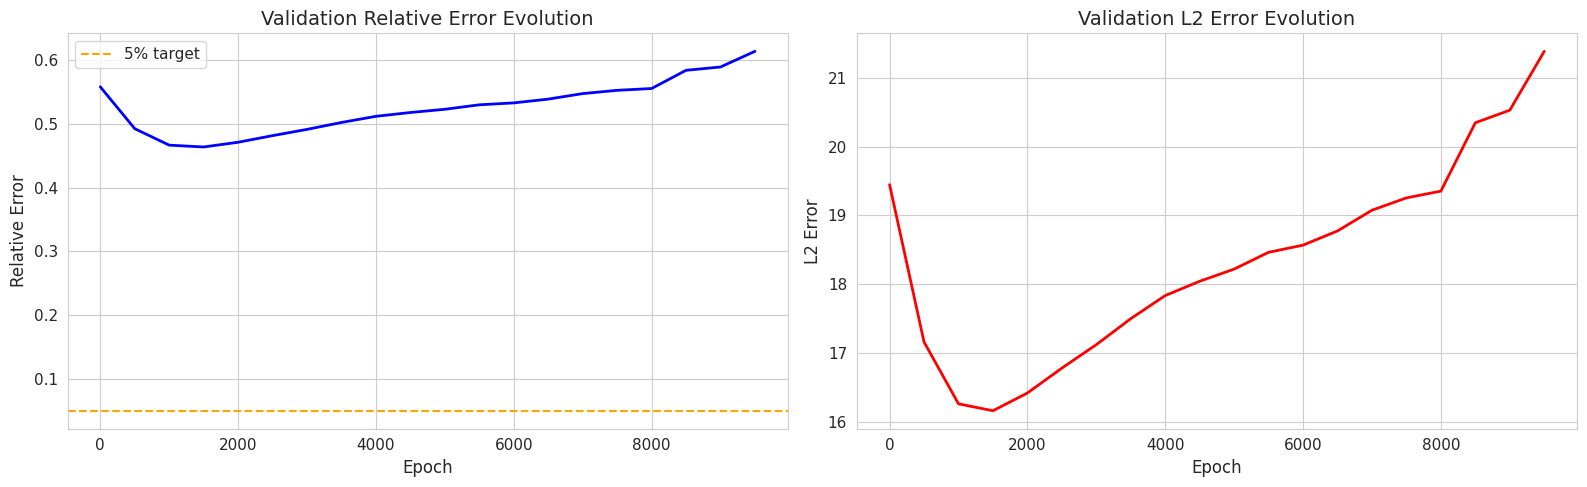


Final Validation Results:
  Relative Error: 0.614275 (61.43%)
  L2 Error: 21.386058

⚠ さらなる改善が必要


In [30]:
# Plot validation errors
if validation_callback.relative_errors:
    epochs = np.arange(0, len(validation_callback.relative_errors)) * validation_callback.validation_interval

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Relative error
    ax1.plot(epochs, validation_callback.relative_errors, "b-", linewidth=2)
    ax1.axhline(0.05, color="orange", linestyle="--", label="5% target")
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Relative Error", fontsize=12)
    ax1.set_title("Validation Relative Error Evolution", fontsize=14)
    ax1.legend()
    ax1.grid(True)

    # L2 error
    ax2.plot(epochs, validation_callback.errors, "r-", linewidth=2)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("L2 Error", fontsize=12)
    ax2.set_title("Validation L2 Error Evolution", fontsize=14)
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(exp_dir / "validation_errors.png", dpi=150)
    plt.show()

    final_rel_error = validation_callback.relative_errors[-1]
    final_l2_error = validation_callback.errors[-1]

    print(f"\nFinal Validation Results:")
    print(f"  Relative Error: {final_rel_error:.6f} ({final_rel_error * 100:.2f}%)")
    print(f"  L2 Error: {final_l2_error:.6f}")

    if final_rel_error < 0.05:
        print("\n✓✓ 優秀！5%目標を達成！")
    elif final_rel_error < 0.10:
        print("\n✓ 良好！10%以内の精度を達成")
    elif final_rel_error < 0.20:
        print("\n△ 改善の余地あり（20%以内）")
    else:
        print("\n⚠ さらなる改善が必要")

## Detailed Predictions and Error Analysis

In [31]:
# Generate predictions at multiple time points
nx = 200
nt = 20
x_test = np.linspace(config.domain.x_min, config.domain.x_max, nx)
t_test = np.linspace(config.domain.t_min, config.domain.t_max, nt)

# Create meshgrid
X, T = np.meshgrid(x_test, t_test, indexing="ij")
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]
XT = np.hstack([X_flat, T_flat])

# PINN predictions
u_pinn_flat = trained_model.predict(XT)
u_pinn = u_pinn_flat.reshape(nx, nt)

# Analytical solution with reflections
L = config.domain.x_max - config.domain.x_min
u_analytical = analytical_solver.traveling_wave_with_reflections(
    x=x_test,
    t=t_test,
    c=config.domain.wave_speed,
    initial_condition=initial_condition,
    L=L,
    n_reflections=10,
)

print(f"Generated predictions on {nx} × {nt} = {nx * nt} points")

Generated predictions on 200 × 20 = 4000 points


## Time-Dependent Error Analysis

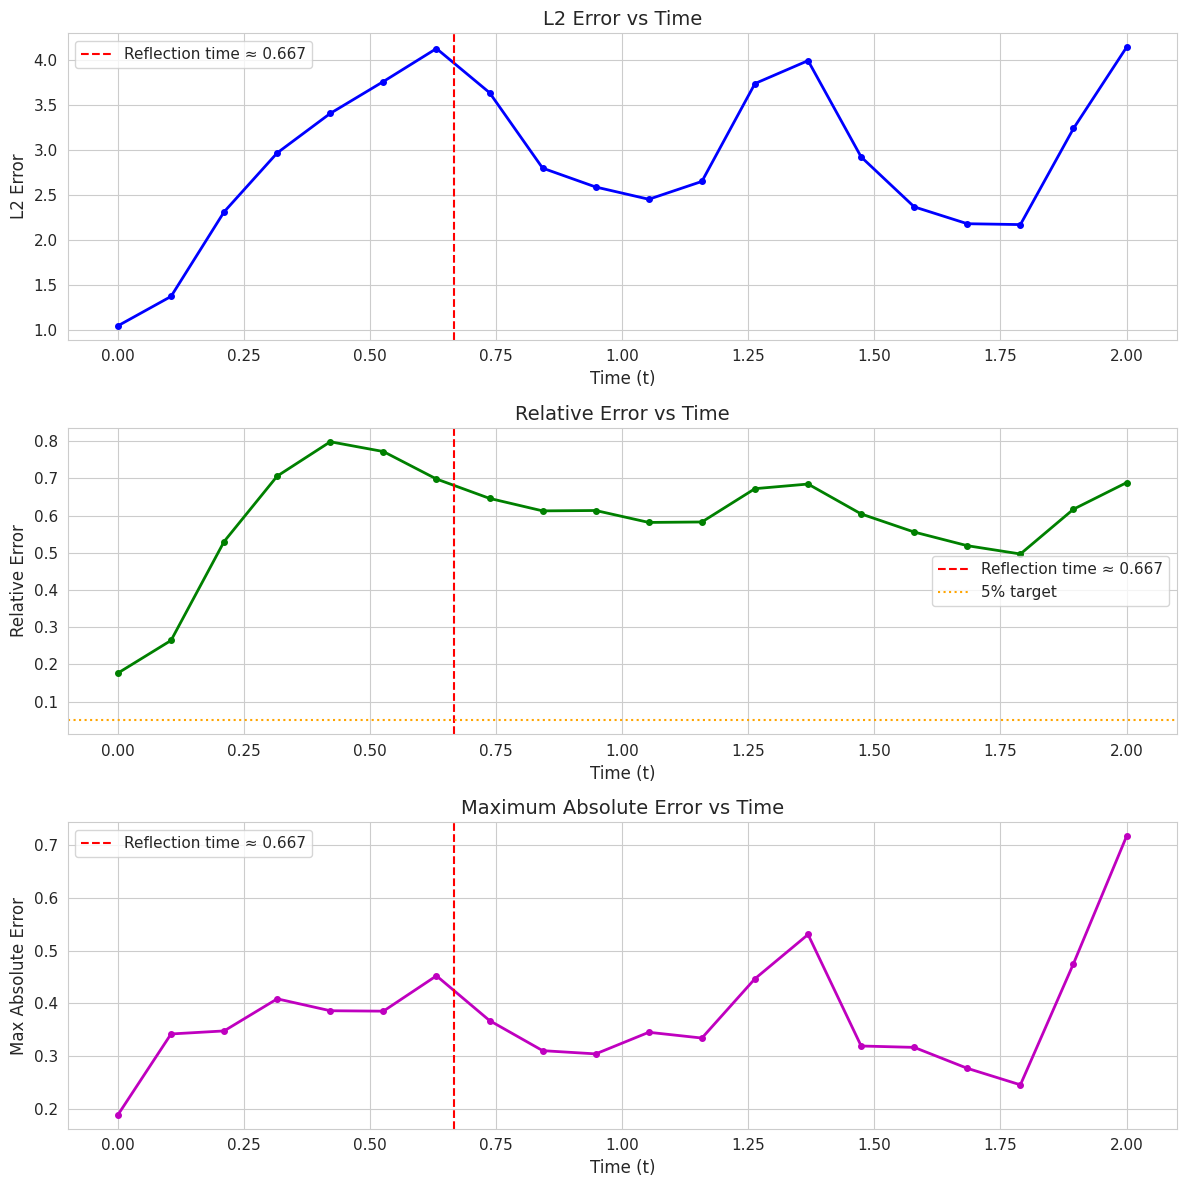


ERROR STATISTICS

Before reflection (t < 0.667):
  Mean relative error: 0.563860 (56.39%)

After reflection (t ≥ 0.667):
  Mean relative error: 0.605883 (60.59%)



In [32]:
# Compute errors at each time step
errors_per_time = []
relative_errors_per_time = []
max_errors_per_time = []

for i in range(nt):
    u_pinn_t = u_pinn[:, i].reshape(-1, 1)
    u_analytical_t = u_analytical[:, i].reshape(-1, 1)

    l2_err = error_metrics.l2_error(u_pinn_t, u_analytical_t)
    rel_err = error_metrics.relative_error(u_pinn_t, u_analytical_t)
    max_err = error_metrics.max_absolute_error(u_pinn_t, u_analytical_t)

    errors_per_time.append(l2_err)
    relative_errors_per_time.append(rel_err)
    max_errors_per_time.append(max_err)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# L2 error
axes[0].plot(t_test, errors_per_time, "b-o", linewidth=2, markersize=4)
axes[0].axvline(t_reflection, color="r", linestyle="--", label=f"Reflection time ≈ {t_reflection:.3f}")
axes[0].set_xlabel("Time (t)", fontsize=12)
axes[0].set_ylabel("L2 Error", fontsize=12)
axes[0].set_title("L2 Error vs Time", fontsize=14)
axes[0].legend()
axes[0].grid(True)

# Relative error
axes[1].plot(t_test, relative_errors_per_time, "g-o", linewidth=2, markersize=4)
axes[1].axvline(t_reflection, color="r", linestyle="--", label=f"Reflection time ≈ {t_reflection:.3f}")
axes[1].axhline(0.05, color="orange", linestyle=":", label="5% target")
axes[1].set_xlabel("Time (t)", fontsize=12)
axes[1].set_ylabel("Relative Error", fontsize=12)
axes[1].set_title("Relative Error vs Time", fontsize=14)
axes[1].legend()
axes[1].grid(True)

# Max absolute error
axes[2].plot(t_test, max_errors_per_time, "m-o", linewidth=2, markersize=4)
axes[2].axvline(t_reflection, color="r", linestyle="--", label=f"Reflection time ≈ {t_reflection:.3f}")
axes[2].set_xlabel("Time (t)", fontsize=12)
axes[2].set_ylabel("Max Absolute Error", fontsize=12)
axes[2].set_title("Maximum Absolute Error vs Time", fontsize=14)
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig(exp_dir / "error_vs_time.png", dpi=150)
plt.show()

# Statistics
print("\n" + "=" * 80)
print("ERROR STATISTICS")
print("=" * 80)

mask_before = t_test < t_reflection
mask_after = t_test >= t_reflection

if np.any(mask_before):
    mean_rel_before = np.mean(np.array(relative_errors_per_time)[mask_before])
    print(f"\nBefore reflection (t < {t_reflection:.3f}):")
    print(f"  Mean relative error: {mean_rel_before:.6f} ({mean_rel_before * 100:.2f}%)")

if np.any(mask_after):
    mean_rel_after = np.mean(np.array(relative_errors_per_time)[mask_after])
    print(f"\nAfter reflection (t ≥ {t_reflection:.3f}):")
    print(f"  Mean relative error: {mean_rel_after:.6f} ({mean_rel_after * 100:.2f}%)")

print("\n" + "=" * 80)

## Solution Snapshots at Multiple Times

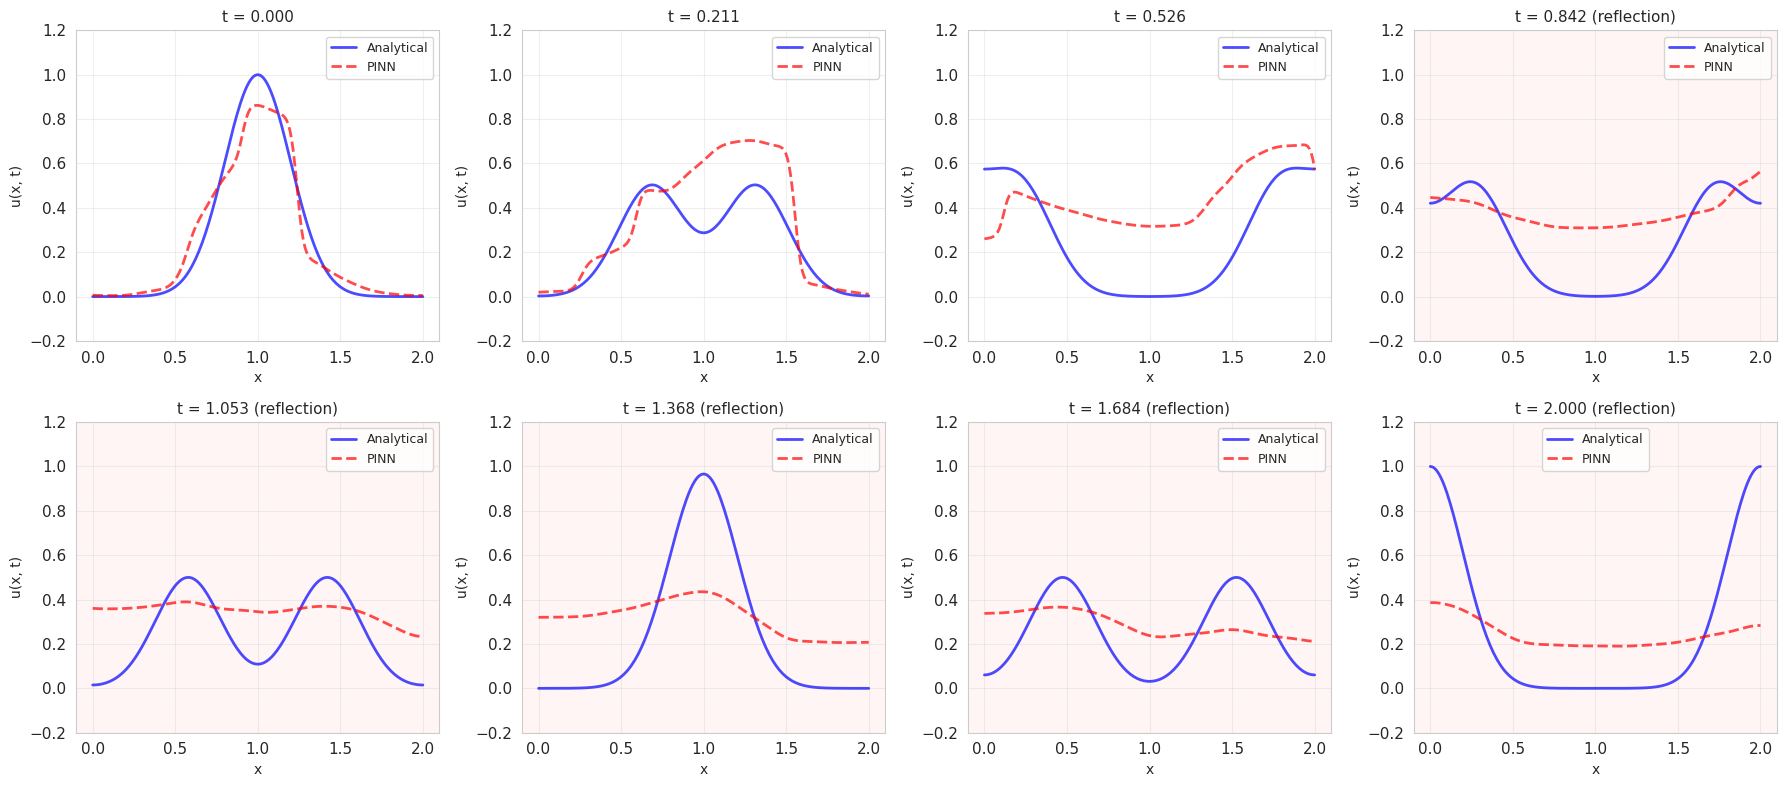

In [33]:
# Select time snapshots
n_snapshots = 8
time_indices = np.linspace(0, nt - 1, n_snapshots, dtype=int)
time_snapshots = t_test[time_indices]

# Plot
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, (t_idx, t_val) in enumerate(zip(time_indices, time_snapshots)):
    ax = axes[i]

    ax.plot(x_test, u_analytical[:, t_idx], "b-", linewidth=2, label="Analytical", alpha=0.7)
    ax.plot(x_test, u_pinn[:, t_idx], "r--", linewidth=2, label="PINN", alpha=0.7)

    if t_val >= t_reflection:
        ax.set_facecolor("#fff5f5")
        title_suffix = " (reflection)"
    else:
        title_suffix = ""

    ax.set_xlabel("x", fontsize=10)
    ax.set_ylabel("u(x, t)", fontsize=10)
    ax.set_title(f"t = {t_val:.3f}{title_suffix}", fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-0.2, 1.2])

plt.tight_layout()
plt.savefig(exp_dir / "solution_snapshots.png", dpi=150)
plt.show()

## Spatiotemporal Heatmap Comparison

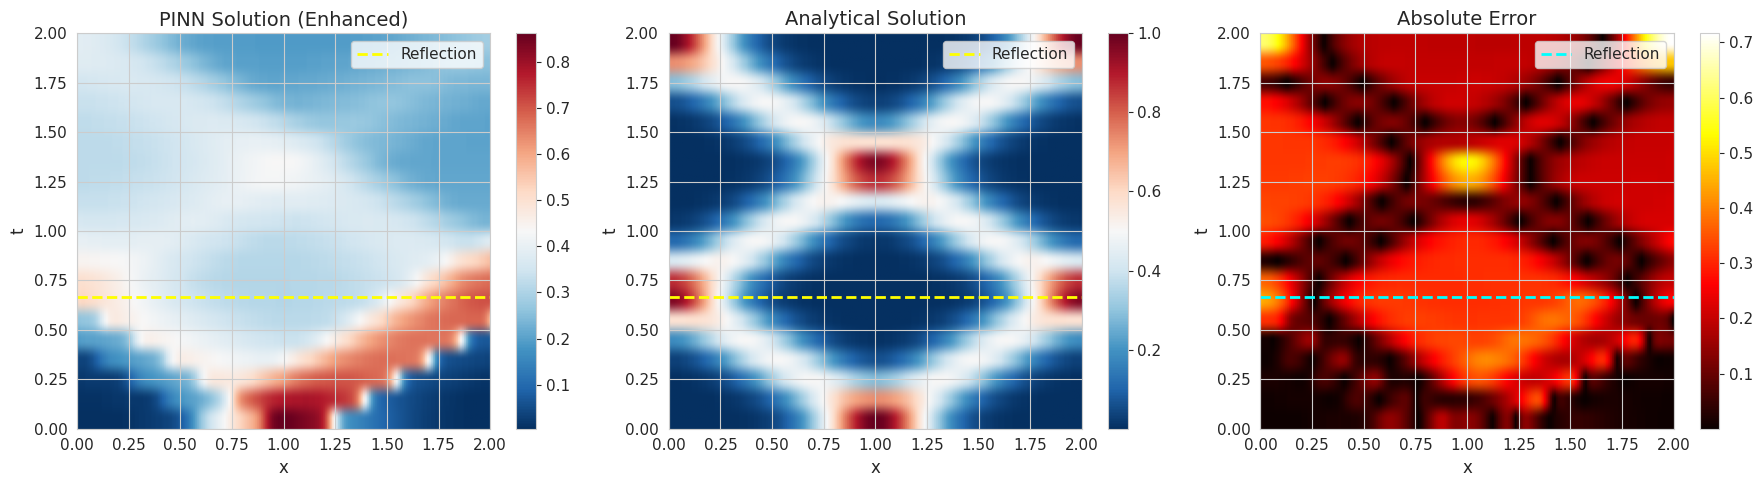

In [34]:
# Create heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PINN solution
im1 = axes[0].imshow(
    u_pinn.T,
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    extent=[config.domain.x_min, config.domain.x_max, config.domain.t_min, config.domain.t_max],
)
axes[0].axhline(t_reflection, color="yellow", linestyle="--", linewidth=2, label="Reflection")
axes[0].set_xlabel("x", fontsize=12)
axes[0].set_ylabel("t", fontsize=12)
axes[0].set_title("PINN Solution (Enhanced)", fontsize=14)
axes[0].legend()
plt.colorbar(im1, ax=axes[0])

# Analytical solution
im2 = axes[1].imshow(
    u_analytical.T,
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    extent=[config.domain.x_min, config.domain.x_max, config.domain.t_min, config.domain.t_max],
)
axes[1].axhline(t_reflection, color="yellow", linestyle="--", linewidth=2, label="Reflection")
axes[1].set_xlabel("x", fontsize=12)
axes[1].set_ylabel("t", fontsize=12)
axes[1].set_title("Analytical Solution", fontsize=14)
axes[1].legend()
plt.colorbar(im2, ax=axes[1])

# Error
error_map = np.abs(u_pinn - u_analytical)
im3 = axes[2].imshow(
    error_map.T,
    aspect="auto",
    origin="lower",
    cmap="hot",
    extent=[config.domain.x_min, config.domain.x_max, config.domain.t_min, config.domain.t_max],
)
axes[2].axhline(t_reflection, color="cyan", linestyle="--", linewidth=2, label="Reflection")
axes[2].set_xlabel("x", fontsize=12)
axes[2].set_ylabel("t", fontsize=12)
axes[2].set_title("Absolute Error", fontsize=14)
axes[2].legend()
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.savefig(exp_dir / "spatiotemporal_comparison.png", dpi=150)
plt.show()

## Final Summary

In [35]:
# Overall metrics
overall_l2 = error_metrics.l2_error(u_pinn, u_analytical)
overall_rel = error_metrics.relative_error(u_pinn, u_analytical)
overall_max = error_metrics.max_absolute_error(u_pinn, u_analytical)

print("\n" + "=" * 80)
print("ENHANCED TRAVELING WAVE PINN - FINAL RESULTS")
print("=" * 80)

print("\n【Overall Metrics】")
print(f"  L2 Error:        {overall_l2:.6f}")
print(f"  Relative Error:  {overall_rel:.6f} ({overall_rel * 100:.2f}%)")
print(f"  Max Error:       {overall_max:.6f}")

print("\n【Enhanced Features】")
print("  ✓ Fourier Features: ENABLED")
print("  ✓ Causal Training: ENABLED")

if np.any(mask_before) and np.any(mask_after):
    mean_rel_before = np.mean(np.array(relative_errors_per_time)[mask_before])
    mean_rel_after = np.mean(np.array(relative_errors_per_time)[mask_after])

    print(f"\n【Before Reflection】 (t < {t_reflection:.3f})")
    print(f"  Mean relative error: {mean_rel_before:.4f} ({mean_rel_before * 100:.2f}%)")

    print(f"\n【After Reflection】 (t ≥ {t_reflection:.3f})")
    print(f"  Mean relative error: {mean_rel_after:.4f} ({mean_rel_after * 100:.2f}%)")

print("\n【Conclusion】")
if overall_rel < 0.05:
    print("  ✓✓✓ 素晴らしい！5%目標を達成！")
    print("  Fourier Features + Causal Training が非常に効果的")
elif overall_rel < 0.10:
    print("  ✓✓ 優秀！10%以内の精度を達成")
    print("  Fourier Features + Causal Training が効果的")
elif overall_rel < 0.20:
    print("  ✓ 良好！20%以内の精度を達成")
    print("  さらなる改善の余地あり")
else:
    print("  △ 改善されたが、さらなる調整が推奨される")
    print("  エポック数やネットワークサイズの増加を検討")

print(f"\n{'=' * 80}")
print(f"Results saved to: {exp_dir}")
print(f"{'=' * 80}")


ENHANCED TRAVELING WAVE PINN - FINAL RESULTS

【Overall Metrics】
  L2 Error:        13.509313
  Relative Error:  0.608426 (60.84%)
  Max Error:       0.716613

【Enhanced Features】
  ✓ Fourier Features: ENABLED
  ✓ Causal Training: ENABLED

【Before Reflection】 (t < 0.667)
  Mean relative error: 0.5639 (56.39%)

【After Reflection】 (t ≥ 0.667)
  Mean relative error: 0.6059 (60.59%)

【Conclusion】
  △ 改善されたが、さらなる調整が推奨される
  エポック数やネットワークサイズの増加を検討

Results saved to: /home/manat/project3/experiments/traveling_wave_enhanced_2026-01-08_09-44-32
